In [ ]:
import os
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
import textstat
from collections import Counter
import language_tool_python
from sklearn.pipeline import Pipeline
import pickle 
import spacy
# Load the English NER model
nlp = spacy.load("en_core_web_sm")
tool = language_tool_python.LanguageTool('en-US')
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BertForMaskedLM, BertTokenizer
import torch
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix,accuracy_score

In [8]:
data22 = pd.read_csv("sample23.csv")

In [20]:
#Punctuation count
def punctuation_count(text):
    punctuation = re.findall(r'[^\w\s]',text)
    return len(punctuation)

#word count
def word_count_regex(text):
    words = re.findall(r'\b\w+\b', text)
    return len(words)

#noun count
def noun_count(text):
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    noun_count = sum(1 for _, tag in tagged_tokens if tag.startswith('NN'))
    return noun_count

#verb count
def verb_count(text):
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    verb_count = sum(1 for _, tag in tagged_tokens if tag.startswith('VB'))
    return verb_count

#adjective count
def adj_count(text):
    tokens = word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    adj_count = sum(1 for _, tag in tagged_tokens if tag.startswith('JJ'))
    return adj_count

#Average sentence length
def  average_sentence(text):
    # Split the text into sentences
    sentences = nltk.sent_tokenize(text)
    # Split each sentence into words and calculate the length of each sentence
    sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]
    # Calculate the average sentence length
    if sentence_lengths:
        avg_length = sum(sentence_lengths) / len(sentence_lengths)
    else:
        avg_length = 0
    return avg_length

#number of named entity
def count_ner_tokens(text):
    doc = nlp(text)
    ner_count = len(doc.ents)
    return ner_count


# function to calculate readability scores
def calculate_readability_scores(text):
    return pd.Series({
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'gunning_fog': textstat.gunning_fog(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
        'ari': textstat.automated_readability_index(text),
        'linsear_write_formula': textstat.linsear_write_formula(text),
        'spache_readability': textstat.spache_readability(text)
    })


#number of grammatical errors 
def count_grammatical_errors(text):
    matches = tool.check(text)
    return len(matches)


#number of unique words in a text 
def hapax_legomena_count(text):
    # Tokenize the text into words
    words = text.split()
        # Return 0 if there are no words to avoid division by zero
    if len(words) == 0:
        return 0
    # Count the frequency of each word
    word_counts = Counter(words)
    # Hapax legomena are words that appear exactly once
    hapax_legomena = [word for word, count in word_counts.items() if count == 1]
    hapax_ratio = len(hapax_legomena)/len(words)
    return hapax_ratio


def split_text(text, tokenizer, max_length):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]
    return chunks

def calculate_perplexity(model, tokenizer, tokens):
    tokens_tensor = torch.tensor(tokens).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(tokens_tensor, labels=tokens_tensor)
        loss = outputs.loss.item()
    return np.exp(loss)

def calculate_perplexities(text, gpt2_model_name='gpt2', bert_model_name='bert-base-uncased', max_length=512, random_seed=42):
    # Set random seed for consistency
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Load GPT-2 model and tokenizer
    gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
    gpt2_model.eval()

    # Load BERT model and tokenizer
    bert_model = BertForMaskedLM.from_pretrained(bert_model_name)
    bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    bert_model.eval()

    # Split the input text into chunks for GPT-2
    gpt2_chunks = split_text(text, gpt2_tokenizer, max_length=1024)
    
    # Calculate perplexity for each chunk and average them for GPT-2
    gpt2_perplexities = [calculate_perplexity(gpt2_model, gpt2_tokenizer, chunk) for chunk in gpt2_chunks]
    avg_gpt2_perplexity = np.mean(gpt2_perplexities)

    # Split the input text into chunks for BERT
    bert_chunks = split_text(text, bert_tokenizer, max_length=512)
    
    # Calculate perplexity for each chunk and average them for BERT
    bert_perplexities = []
    mask_token = bert_tokenizer.mask_token_id

    for chunk in bert_chunks:
        if len(chunk) > 2:  # Ensure there are enough tokens to mask
            masked_chunk = chunk.copy()
            mask_position = np.random.randint(1, len(masked_chunk) - 1)
            masked_chunk[mask_position] = mask_token
            bert_perplexity = calculate_perplexity(bert_model, bert_tokenizer, masked_chunk)
            bert_perplexities.append(bert_perplexity)
    
    avg_bert_perplexity = np.mean(bert_perplexities) if bert_perplexities else float('inf')

    return avg_gpt2_perplexity, avg_bert_perplexity


def extract_features(text):
    
    gpt2_perplexity, bert_perplexity = calculate_perplexities(text)
    # Call each feature extraction function and collect the results
    features = {
        "word_count_regex": word_count_regex(text),
        "punctuation_count": punctuation_count(text),
        "verb_count": verb_count(text),
        "adj_count": adj_count(text),
        "noun_count": noun_count(text),
        " average_sentence": average_sentence(text),
        "count_ner_tokens": count_ner_tokens(text),
        "count_grammatical_errors": count_grammatical_errors(text),
        "hapax_legomena_count": hapax_legomena_count(text),
        **calculate_readability_scores(text), # Merge readability scores
        "gpt2_perplexity": gpt2_perplexity,
        "bert_perplexity": bert_perplexity
        }
    return features
#features_df = pd.DataFrame(features, index=[0])

In [9]:
chunk_size = 1000  

# Initialize an empty list to hold the processed chunks
processed_chunks = []
for chunk in pd.read_csv("sample23.csv", chunksize=chunk_size):
  # Apply the functions to the 'text' column
   chunk['word_count_regex'] = chunk['text'].apply(word_count_regex)
   chunk['punctuation_count'] = chunk['text'].apply(punctuation_count)
   chunk['verb_count'] = chunk['text'].apply(verb_count)
   chunk['adj_count'] = chunk['text'].apply(adj_count)
   chunk['noun_count'] = chunk['text'].apply(noun_count)
   chunk[' average_sentence'] = chunk['text'].apply(average_sentence)
   chunk['count_ner_tokens'] = chunk['text'].apply(count_ner_tokens)
   chunk['count_grammatical_errors'] = chunk['text'].apply(count_grammatical_errors)
   chunk['hapax_legomena_count'] = chunk['text'].apply(hapax_legomena_count)
   #append the processed chunk to the list
   processed_chunks.append(chunk)

# Concatenate all processed chunks into a single DataFrame
processed_data = pd.concat(processed_chunks, ignore_index=True)
# Combine the readability scores with the original data
readability_scores_df = processed_data['text'].apply(calculate_readability_scores)
readability_scores_df[['gpt2_perplexity', 'bert_perplexity']] = readability_scores_df['text'].apply(
    lambda x: pd.Series(calculate_perplexities(x))
)
combined_df = pd.concat([processed_data, readability_scores_df], axis=1)
combined_df.to_csv('final.csv', index=False)

In [71]:
import shap
combined_df = pd.read_csv("final.csv")
combined_df = combined_df.dropna()
#splitting the dataset into X and Y
X = combined_df.iloc[:,list(range(2, combined_df.shape[1]))]
Y = combined_df.iloc[:,1]

#splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#loading scaler 
scaler = StandardScaler()

#scaling train dataset
X_train_scaled = scaler.fit_transform(X_train)

#fitting the model 
svm = SVC(kernel='rbf',probability = True) 
svm.fit(X_train_scaled, y_train)

SVC(probability=True)

In [73]:
X_test_scaled = scaler.transform(X_test)
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9875

In [63]:
# Create DataFrame for plotting
train_data = X_train.copy()
train_data['label'] = y_train.values
train_data['dataset'] = 'Training'

test_data = X_test.copy()
test_data['label'] = y_test.values
test_data['dataset'] = 'Testing'

combined_data = pd.concat([train_data, test_data])

C:\Users\PC\AppData\Local\Temp\ipykernel_12728\2755023828.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=size_df, x='Dataset', y='Size', palette='viridis')


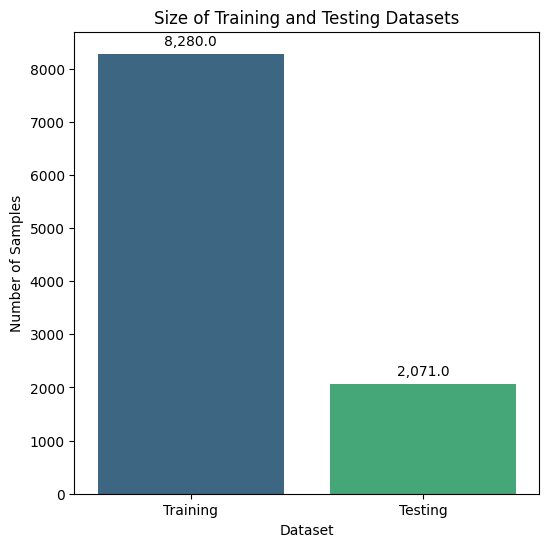

In [ ]:
model = pickle.load(open('model3.pkl', 'rb'))
background_data = shap.sample(X_train, 100)
explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer.shap_values(X_test,nsamples=100)

  0%|          | 0/6000 [00:00<?, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

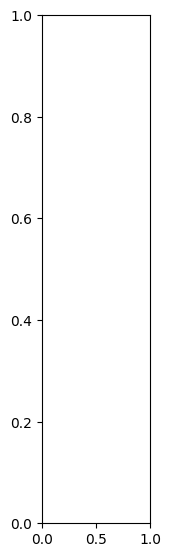

In [48]:
column_names = combined_df.columns.tolist()
feature_names = column_names[2:]
shap.summary_plot(shap_values, X_test,feature_names = feature_names)

In [42]:
print("Column names:", column_names)

Column names: ['text', 'generated', 'word_count_regex', 'punctuation_count', 'verb_count', 'adj_count', 'noun_count', ' average_sentence', 'count_ner_tokens', 'count_grammatical_errors', 'hapax_legomena_count', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'coleman_liau_index', 'dale_chall_readability_score', 'ari', 'linsear_write_formula', 'spache_readability', 'gpt2_perplexity', 'bert_perplexity']


In [43]:
print("Feature names:", feature_names)

Feature names: ['word_count_regex', 'punctuation_count', 'verb_count', 'adj_count', 'noun_count', ' average_sentence', 'count_ner_tokens', 'count_grammatical_errors', 'hapax_legomena_count', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'coleman_liau_index', 'dale_chall_readability_score', 'ari', 'linsear_write_formula', 'spache_readability', 'gpt2_perplexity', 'bert_perplexity']


In [44]:
print("X columns:", X.columns.tolist())

X columns: ['word_count_regex', 'punctuation_count', 'verb_count', 'adj_count', 'noun_count', ' average_sentence', 'count_ner_tokens', 'count_grammatical_errors', 'hapax_legomena_count', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'coleman_liau_index', 'dale_chall_readability_score', 'ari', 'linsear_write_formula', 'spache_readability', 'gpt2_perplexity', 'bert_perplexity']


In [45]:
print("SHAP values shape:", shap_values.shape)

SHAP values shape: (6000, 19, 2)


In [46]:
print("X_test shape:", X_test.shape)

X_test shape: (6000, 19)


In [40]:
feature_names

['word_count_regex',
 'punctuation_count',
 'verb_count',
 'adj_count',
 'noun_count',
 ' average_sentence',
 'count_ner_tokens',
 'count_grammatical_errors',
 'hapax_legomena_count',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'gunning_fog',
 'coleman_liau_index',
 'dale_chall_readability_score',
 'ari',
 'linsear_write_formula',
 'spache_readability',
 'gpt2_perplexity',
 'bert_perplexity']

In [30]:
#Model performance measure 
X_test_scaled = scaler.transform(X_test)
#y_pred = svm.predict(X_test_scaled)
""""
#model accuracy
accuracy = accuracy_score(y_test, y_pred)

#recall score
recall = recall_score(y_test, y_pred)

# Precision score
precision = precision_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

"""

AttributeError: 'StandardScaler' object has no attribute 'mean_'

In [ ]:
features = extract_features(x)
features_df = pd.DataFrame(features, index=[0])
features_df

In [12]:
#Feature importance 
